[](http://e7.pngegg.com/pngimages/360/846/png-clipart-human-behavior-thumb-homo-sapiens-sarcasm-logo-cartoon.png)

# Introduction...


### Acknowledgement
The information below was obtained from: https://www.techtarget.com/searchbusinessanalytics/definition/opinion-mining-sentiment-mining

### What is sentiment analysis?
Sentiment analysis, also referred to as opinion mining, is an approach to natural language processing that identifies the emotional tone behind a body of text. This is a popular way for organizations to determine and categorize opinions about a product, service, or idea. It involves the use of data mining, machine learning and artificial intelligence to mine text for sentiment and subjective information.

Sentiment analysis systems help organizations gather insights from unorganized and unstructured text that comes from online sources such as emails, blog posts, support tickets, web chats, social media channels, forums and comments. Algorithms replace manual data processing by implementing rule-based, automatic or hybrid methods. Rule-based systems perform sentiment analysis based on predefined, lexicon-based rules while automatic systems learn from data with machine learning techniques. A hybrid sentiment analysis combines both approaches.

In addition to identifying sentiment, opinion mining can extract the polarity (or the amount of positivity and negativity), subject and opinion holder within the text. Furthermore, sentiment analysis can be applied to varying scopes such as document, paragraph, sentence and sub-sentence levels.

### Types of sentiment analysis
Fine-grained sentiment analysis provides a more precise level of polarity by breaking it down into further categories, usually very positive to very negative. This can be considered the opinion equivalent of ratings on a 5-star scale.
Emotion detection identifies specific emotions rather than positivity and negativity. Examples could include happiness, frustration, shock, anger and sadness.
Intent-based analysis recognizes actions behind a text in addition to opinion. For example, an online comment expressing frustration about changing a battery could prompt customer service to reach out to resolve that specific issue.
Aspect-based analysis gathers the specific component being positively or negatively mentioned. For example, a customer might leave a review on a product saying the battery life was too short. Then, the system will return that the negative sentiment is not about the product as a whole, but about the battery life.

Import necessary libraries...


In [1]:
! pip install textblob tensorflow

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn import model_selection, preprocessing, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from termcolor import colored
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from tqdm import tqdm
import re

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", "green"))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
file = open("./data/Sarcasm_Headlines_Dataset_v2.json")
json_data = [json.loads(line) for line in file]
json_data[0:5]

In [ ]:
texts = []
labels = []
urls = []

for item in json_data:
    texts.append(item["headline"])
    labels.append(item["is_sarcastic"])
    urls.append(item["article_link"])

In [ ]:
texts[0:10]

In [ ]:
labels[0:10]

In [ ]:
urls[0:5] #we do not need the urls and will not use them

In [ ]:
len(texts), len(labels), len(urls)

In [ ]:
df = pd.DataFrame()
df["text"] = texts
df["label"] = labels
df.head(n = 10).style.background_gradient(cmap = "autumn")

In [ ]:
#get basic information about dataset

df.info()

In [ ]:
#check whether there are duplicated values

df.duplicated().sum()

In [ ]:
# drop duplicated values from the dataset

df.drop_duplicates(inplace = True)

In [ ]:
#get the number of classes of the "label" variable of dataset

df.groupby("label").count().style.background_gradient(cmap = "autumn")

# Visualization with Word Cloud

In [ ]:
text = " ".join(i for i in df.text)

wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

# Preprocess the dataset

In [ ]:
#convert uppercase letters to lowercase letters

df["text"] = df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nCONVERTED SUCCESFULLY...", "green"))

In [ ]:
#delete punctuation marks

df["text"] = df["text"].str.replace('[^\w\s]','')

print(colored("\nDELETED PUNCTUATION MARKS SUCCESFULLY...", "green"))

In [ ]:
#delete numbers

df["text"] = df["text"].str.replace('\d','')

print(colored("\n NUMBERS DELETED SUCCESFULLY...", "green"))

In [ ]:
#delete stopwords

sw = stopwords.words("english")
df["text"] = df["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

print(colored("\nSTOPWORDS DELETED SUCCESFULLY...", "green"))

In [ ]:
#lemmatization. That is, we get the roots of the words

df["text"] = df["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nDONE SUCCESFULLY...", "green"))

In [ ]:
#look at the latest condition of the dataset

df.head(n = 10).style.background_gradient(cmap = "summer")

In [ ]:
#divide the dataset into test and train sets

x = df["text"]
y = df["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y,
                                                                    test_size = 0.20,
                                                                    shuffle = True,
                                                                    random_state = 11)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))

In [ ]:
print(train_x.shape, test_x.shape)

# Vectorize dataset with TFidfVectorizer method...

In [ ]:
tf_idf_word_vectorizer = TfidfVectorizer(analyzer = "word")
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

# Build machine learning models...

## Logistic regression model

#### What is logistic regression?

The information was obtained from:
https://www.ibm.com/topics/logistic-regression#:~:text=Logistic%20regression%20estimates%20the%20probability,bounded%20between%200%20and%201.

This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1. In logistic regression, a logit transformation is applied on the odds—that is, the probability of success divided by the probability of failure. This is also commonly known as the log odds, or the natural logarithm of odds, and this logistic function is represented by the following formulas:
$$
Logit(pi) = 1/(1+ exp(-pi))
$$
$$
ln(pi/(1-pi)) = Beta_0 + Beta_1*X_1 + … + B_k*K_k
$$
In this logistic regression equation, logit(pi) is the dependent or response variable and x is the independent variable. The beta parameter, or coefficient, in this model is commonly estimated via maximum likelihood estimation (MLE). This method tests different values of beta through multiple iterations to optimize for the best fit of log odds. All of these iterations produce the log likelihood function, and logistic regression seeks to maximize this function to find the best parameter estimate. Once the optimal coefficient (or coefficients if there is more than one independent variable) is found, the conditional probabilities for each observation can be calculated, logged, and summed together to yield a predicted probability. For binary classification, a probability less than .5 will predict 0 while a probability greater than 0 will predict 1.  After the model has been computed, it’s best practice to evaluate the how well the model predicts the dependent variable, which is called goodness of fit. The Hosmer–Lemeshow test is a popular method to assess model fit.

Log odds can be difficult to make sense of within a logistic regression data analysis. As a result, exponentiating the beta estimates is common to transform the results into an odds ratio (OR), easing the interpretation of results. The OR represents the odds that an outcome will occur given a particular event, compared to the odds of the outcome occurring in the absence of that event. If the OR is greater than 1, then the event is associated with a higher odds of generating a specific outcome. Conversely, if the OR is less than 1, then the event is associated with a lower odds of that outcome occurring. Based on the equation from above, the interpretation of an odds ratio can be denoted as the following: the odds of a success changes by exp(cB_1) times for every c-unit increase in x. To use an example, let’s say that we were to estimate the odds of survival on the Titanic given that the person was male, and the odds ratio for males was .0810. We’d interpret the odds ratio as the odds of survival of males decreased by a factor of .0810 when compared to females, holding all other variables constant.

In [ ]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nLogistic regression model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)

## Xtreme gradient boosting

#### What is XGBoost?

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

In [ ]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nXGBoost model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)

## Light gradient boosting machines

#### What is Light GBM?

The information was obtained from:
https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

LightGBM is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm. LightGBM extends the gradient boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This can result in a dramatic speedup of training and improved predictive performance. As such, LightGBM has become a de facto algorithm for machine learning competitions when working with tabular data for regression and classification predictive modeling tasks. As such, it owns a share of the blame for the increased popularity and wider adoption of gradient boosting methods in general, along with Extreme Gradient Boosting (XGBoost).

In [ ]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print("\nLight GBM model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)

# ROC AUC (Light GBM model)

In [ ]:
y = train_y
X = x_train_tf_idf_word.astype("float64")

logit_roc_auc = roc_auc_score(y, lgbm_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, lgbm_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

# Estimation over test set (logistic regression model)

In [ ]:
log_model.predict(x_test_tf_idf_word)[0:5]

In [ ]:
log_model.predict_proba(x_test_tf_idf_word)[0:5]

In [ ]:
#plotting confusion matrix

# ConfusionMatrixDisplay(log_model, x_test_tf_idf_word, test_y,
#                       cmap = plt.cm.Reds, normalize = "true");

In [ ]:
print(classification_report(test_y, log_model.predict(x_test_tf_idf_word.astype("float64"))))

# Build deep learning models...

In [ ]:
unique_words = set()
len_max = 0

for sent in tqdm(train_x):
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

In [ ]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(train_x))

train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(train_x, maxlen=len_max)
test_x = sequence.pad_sequences(test_x, maxlen=len_max)

print(train_x.shape, test_x.shape)

In [ ]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = "auto", verbose = 1,
                               monitor = "val_acc",
                               patience = 3)
callbacks = [early_stopping]

## Acknowledgement:
The information below was obtained from:
https://intellipaat.com/blog/what-is-lstm/

#### Long Short-term Memory (LSTM)

LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images. This finds application in speech recognition, machine translation, etc. LSTM is a special kind of RNN, which shows outstanding performance on a large variety of problems.

#### The Logic Behind LSTM

The central role of an LSTM model is held by a memory cell known as a ‘cell state’ that maintains its state over time. The cell state is the horizontal line that runs through the top of the below diagram. It can be visualized as a conveyor belt through which information just flows, unchanged. Information can be added to or removed from the cell state in LSTM and is regulated by gates. These gates optionally let the information flow in and out of the cell. It contains a pointwise multiplication operation and a sigmoid neural net layer that assist the mechanism.

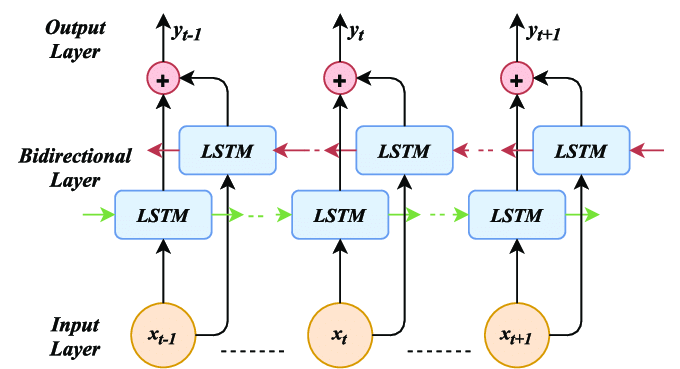


#### What are Bidirectional LSTMs?
These are like an upgrade over LSTMs. In bidirectional LSTMs, each training sequence is presented forward and backward so as to separate recurrent nets. Both sequences are connected to the same output layer. Bidirectional LSTMs have complete information about every point in a given sequence, everything before and after it.

But, how do you rely on the information that hasn’t happened yet? The human brain uses its senses to pick up information from words, sounds, or from whole sentences that might, at first, make no sense but mean something in a future context. Conventional recurrent neural networks are only capable of using the previous context to get information. Whereas, in bidirectional LSTMs, the information is obtained by processing the data in both directions within two hidden layers, pushed toward the same output layer. This helps bidirectional LSTMs access long-range context in both directions.

In [ ]:
model = Sequential()
model.add(Embedding(len(list(unique_words)), 100, input_length = len_max))
model.add(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = True))
model.add(Dense(25, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 0.0045),
              metrics = ["accuracy"])
model.summary()

In [ ]:
history = model.fit(train_x, train_y, epochs = 5, validation_data = (test_x, test_y), 
                  batch_size = 16, verbose = 1, callbacks = callbacks)

In [ ]:
epoch_num = range(1, len(history.history["loss"]) + 1)
plt.plot(epoch_num, history.history["loss"], "r--")
plt.plot(epoch_num, history.history["val_loss"], "b-")
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Epoch numbers")
plt.ylabel("Loss")
plt.show()